In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
import qutip
import scipy.constants
import scipy.special

from sympy import cos, degree, lambdify, sin, Symbol
from sympy.polys.polyerrors import BasePolynomialError

/home/phyks/.local/share/virtualenvs/physique/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/phyks/.local/share/virtualenvs/physique/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # Larger figures by default
plt.rcParams['text.usetex'] = True  # Use LaTeX rendering

# Nice plots
import seaborn
seaborn.set_palette(seaborn.color_palette("Set2", 10))

In [3]:
def total_degree(expr, vars):
    """
    Compute the total degree of a term.

    :param expr: A polynomial expression.
    :param vars: A list of sympy symbols.
    :returns: The total degree of this expression in vars.
    """
    degrees = []
    for var in vars:
        try:
            degrees.append(degree(expr, gen=var))
        except BasePolynomialError:
            pass
    return sum(degrees)


def cosm(A):
    """
    Cosine of a matrix.
    """
    return 0.5 * ((1j*A).expm() + (-1j*A).expm())


def sinm(A):
    """
    Sine of a matrix.
    """
    return (1.0 / (2.0j)) * ((1j*A).expm() - (-1j*A).expm())

## Parameters

_Note_: `phi` stands for reduced fluxes.

In [8]:
# Flux quantum
reduced_flux_quantum = scipy.constants.physical_constants["mag. flux quantum"][0] / (2 * np.pi)

# Size of the Hilbert space
real_hilbert_space_size = 3
N = 20
N = {
    "a": N,
    "b": N,
    "c": N
}

# Mode frequencies, in Hz
omega_0 = {
    "a": None,  # Left blank and filled by frequency matching condition
    # Values in the GHz range, taken so that omega["a"] was not too large
    "b": (2 * np.pi) * 7 * 10**9,
    "c": (2 * np.pi) * 2 * 10**9
}

# Critical current of the junction, in A, from Flavius
I_0 = 3 * 10**(-6)

# Shunt inductances, in H, from Flurin
L_shunt = 30 * 10**(-12)

# Resonators inductances, in H, from Flurin (note that our (a, b) and Flurin's one are inverse)
L_resonators = {
    "a": 10**3 * 10**(-12),
    "b": 500 * 10**(-12),
    "c": None  # Left blank, filled using L_resonators["a"] and L_resonators["b"]
}

# Aspect ratio of the asymmetric JRM (external flux is set to be 2*Pi)
aspect_ratio = 3

# External flux
phi_ext = 2 * np.pi

# Maximum power in series expansion
expansion_order = 6

In [9]:
# Frequency matching condition
omega_0["a"] = (4 * omega_0["c"]) - omega_0["b"]

# E_J junction parameter
E_J = reduced_flux_quantum * I_0

# Josephson inductance
L_J_0 = reduced_flux_quantum / I_0
L_J = lambda phi: (L_J_0 / np.cos(phi))

# Compute L_JRM for each mode
L_JRM = {
    "a": lambda phi_ext: (2 * L_shunt),
    "b": lambda phi_ext: (2 * L_shunt),
    "c": lambda phi_ext: L_shunt
}

# Compute L_resonator for the c mode
L_resonators["c"] = (L_resonators["a"] + L_resonators["b"]) / 4

# Compute total inductances for each mode  # TODO
L_tot = {}
for k in omega_0:
    L_tot[k] = lambda phi_ext, k=k: (L_resonators[k] + L_JRM[k](phi_ext))

# Participation factors
xi = {}
for k in omega_0:
    xi[k] = lambda phi_ext, k=k: (L_JRM[k](phi_ext) / L_tot[k](phi_ext))
    
# Compute resonance frequencies
omega = {}
for k in omega_0:
    omega[k] = lambda phi_ext, k=k: (omega_0[k] * (1 - xi[k](phi_ext) / 2))

# Compute impedances
Z = {}
for k in omega_0:
    Z[k] = lambda phi_ext, k=k: (L_tot[k](phi_ext) * omega[k](phi_ext))

# Phases coefficients  # TODO
phi_0 = {}
for k in omega_0:
    phi_0[k] = lambda phi_ext, k=k: (
        np.sqrt(scipy.constants.hbar * Z[k](phi_ext) / 2) *
        xi[k](phi_ext) / reduced_flux_quantum)

In [10]:
# Evaluate quantities at the given external flux
for k in phi_0:
    phi_0[k] = phi_0[k](phi_ext)
    
for k in Z:
    Z[k] = Z[k](phi_ext)
    
for k in omega:
    omega[k] = omega[k](phi_ext)

for k in xi:
    xi[k] = xi[k](phi_ext)
    
for k in L_tot:
    L_tot[k] = L_tot[k](phi_ext)
    
for k in L_JRM:
    L_JRM[k] = L_JRM[k](phi_ext)

In [11]:
print("omega_0:"); pprint.pprint(omega_0)

print("\nomega:"); pprint.pprint(omega)

print("\nL_JRM:"); pprint.pprint(L_JRM)

print("\nL_resonators:"); pprint.pprint(L_resonators)

print("\nL_tot:"); pprint.pprint(L_tot)

print("\nxi:"); pprint.pprint(xi)

print("\nZ:"); pprint.pprint(Z)

print("\nphi_0:"); pprint.pprint(phi_0)

omega_0:
{'a': 6283185307.179588, 'b': 43982297150.2571, 'c': 12566370614.359173}

omega:
{'a': 6105359307.919788, 'b': 41626102660.06476, 'c': 12100949480.494019}

L_JRM:
{'a': 6e-11, 'b': 6e-11, 'c': 3e-11}

L_resonators:
{'a': 1e-09, 'b': 5e-10, 'c': 3.7500000000000005e-10}

L_tot:
{'a': 1.06e-09, 'b': 5.6e-10, 'c': 4.0500000000000005e-10}

xi:
{'a': 0.056603773584905655, 'b': 0.10714285714285714, 'c': 0.07407407407407407}

Z:
{'a': 6.471680866394976, 'b': 23.310617489636265, 'c': 4.900884539600078}

phi_0:
{'a': 0.0031771757765825357,
 'b': 0.011413725497275724,
 'c': 0.0036181850773886644}


In [8]:
# Estimation of the prefactor in front of the interesting term in the Hamiltonian b {c^\dagger}^4 + h.c.
# This is expressed in Hz, as it is in the hamiltonian below
chi_max = (4 * (E_J / scipy.constants.hbar) *
           sin((aspect_ratio - 1) / (2 * (aspect_ratio + 1))) *
           phi_0["b"] * (phi_0["c"]**4) /
           (2 * scipy.special.factorial(4, exact=True)))
print("|chi|: %f." % (chi_max,))

|chi|: 128734.417754.


## Operators

In [84]:
# X mode operators
a = qutip.tensor(qutip.destroy(N["a"]), qutip.qeye(N["b"]), qutip.qeye(N["c"]))
a_dagger = a.dag()

# Y mode operators
b = qutip.tensor(qutip.qeye(N["a"]), qutip.destroy(N["b"]), qutip.qeye(N["c"]))
b_dagger = b.dag()

# Z mode operators
c = qutip.tensor(qutip.qeye(N["a"]), qutip.qeye(N["b"]), qutip.destroy(N["c"]))
c_dagger = c.dag()

## Phase quantization

In [85]:
phi = {
    "a": phi_0["a"] * (a + a_dagger),
    "b": phi_0["b"] * (b + b_dagger),
    "c": phi_0["c"] * (c + c_dagger),
}

## Hamiltonian

_Note_: `H` is $H / \hbar$.

In [11]:
# Harmonic part of the hamiltonian
H_0 = (omega["a"] * a_dagger * a +
       omega["b"] * b_dagger * b +
       omega["c"] * c_dagger * c)
# Non-linear part of the hamiltonian
phi_X = Symbol("phi_X")
phi_Y = Symbol("phi_Y")
phi_Z = Symbol("phi_Z")
H_1 = (-4 * E_J / scipy.constants.hbar *
       sin(phi_X / 2) *
       sin(phi_Y / 2) * (
           (sin((aspect_ratio - 1) / (2 * (aspect_ratio + 1))) *
            cos(phi_Z)) +
           (cos((aspect_ratio - 1) / (2 * (aspect_ratio + 1))) *
            sin(phi_Z))))

# Note: Use cos and sin as arguments to replace them by cos and sin of matrices
H_1_numpy = lambdify((cos, sin, phi_X, phi_Y, phi_Z), H_1, "numpy")
# Compute the full hamiltonian
H_full = H_0 + H_1_numpy(cosm,
                         sinm,
                         phi["a"],
                         phi["b"],
                         phi["c"])

## Power expansion

In [12]:
# Expand in powers of phi_X and drop big O term
H_expanded_symbolic = H_1.series(
    x=phi_X,
    n=expansion_order).removeO()
# Expand in powers of phi_Y and drop big O term
H_expanded_symbolic = H_expanded_symbolic.series(
    x=phi_Y,
    n=expansion_order).removeO()
# Expand in powers of phi_Z and drop big O term
H_expanded_symbolic = H_expanded_symbolic.series(
    x=phi_Z,
    n=expansion_order).removeO()
H_expanded_symbolic = H_expanded_symbolic.expand()
# Filter out terms of too high order
H_expanded_symbolic = sum([
    i
    for i in H_expanded_symbolic.as_ordered_terms()
    if total_degree(i, [phi_X, phi_Y, phi_Z]) <= expansion_order
])
# Expanded hamiltonian
H_expanded_numpy = lambdify((phi_X, phi_Y, phi_Z),
                            H_expanded_symbolic, "numpy")
H_1_expanded = H_expanded_numpy(phi["a"], phi["b"], phi["c"])
H_expanded = H_0 + H_1_expanded

## RWA approach

In [13]:
# 1st order
H_RWA_1st_order = (-E_J / scipy.constants.hbar / 96 *
                   np.sin((aspect_ratio - 1) / (2 * (aspect_ratio + 1))) *
                   phi_0["a"] * phi_0["b"] * phi_0["c"]**4 *
                   (a * b * c_dagger**4 +
                    a_dagger * b_dagger * c**4))

## Comparisons

In [14]:
# TODO: What are good comparisons?

In [15]:
def projector_onto_first_states(N, n):
    """
    Projector onto the first states of the Fock basis.
    
    :param N: The total size of the Hilbert space.
    :param n: The number of steps to keep.
    """
    return sum([qutip.fock(N, i) * qutip.fock(N, i).dag()
                for i in range(n)])

In [16]:
# Projector onto the real Hilbert space, to discard to high Fock states
project = lambda M: (qutip.tensor(
    projector_onto_first_states(N["a"], real_hilbert_space_size),
    projector_onto_first_states(N["b"], real_hilbert_space_size),
    projector_onto_first_states(N["c"], real_hilbert_space_size)) * M)

In [17]:
print("Full hamiltonian / expanded hamiltonian: %s." %
      (project(H_full - H_expanded).norm("max"),))

Full hamiltonian / expanded hamiltonian: 0.0189554592805.


In [39]:
# This is huge because H_1_expanded has much more coefficients than H_RWA_1st_order
print("Expanded hamiltonian / RWA hamiltonian: %s." %
      (project(H_1_expanded - H_RWA_1st_order).norm("max"),))

Expanded hamiltonian / RWA hamiltonian: 242359022.493.


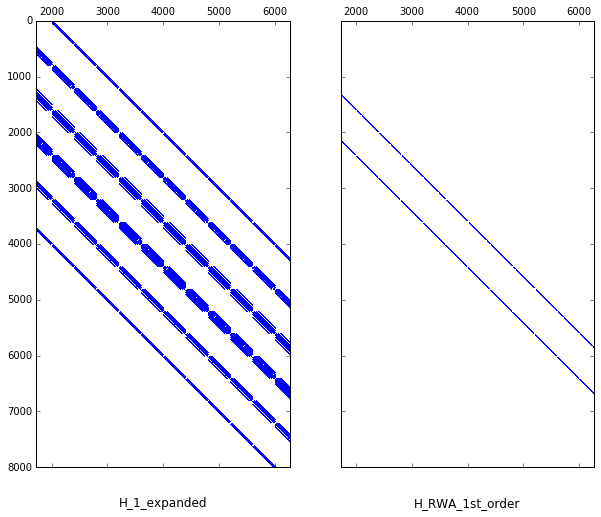

In [74]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.spy(H_1_expanded.data, markersize=1, marker=".")
ax1.set_title("H_1_expanded", y=-0.1)

ax2.spy(H_RWA_1st_order.data, markersize=1, marker=".")
ax2.set_title("H_RWA_1st_order", y=-0.1)
plt.show()

In [73]:
# Compute the maximum difference of coefficients, taking only those non-zero in RWA approx
I1, J1, V1 = scipy.sparse.find(H_RWA_1st_order.data)
I2, J2, V2 = scipy.sparse.find(H_1_expanded.data)

M = 0
for i, j, v in zip(I1, J1, V1):
    if i not in I2 or j not in J2:
        M = max(M, abs(v))
    else:
        M = max(M, abs(v - H_1_expanded.data[i, j]))

print(M)

2.39242264409


## $sin(a + a^{\dagger})$ in terms of displacement operators

`N` is 200 so that the coherent state $|\alpha\rangle$ with $\alpha \approx 10$ does not overlap more than $10^{-9}$ with the latest Fock state in the Hilbert space.

In [16]:
N = 20
s = sinm(0.5*(qutip.destroy(N) + qutip.create(N)))

# Exact computation in terms of expectation value
expect = lambda alpha: qutip.expect(s, qutip.coherent(N, alpha=alpha))

In [17]:
from scipy.optimize import minimize

# Looking for the maximum of this function
max_found = minimize(lambda x: (-1) * expect(x[0]), 0)
print(max_found)

      fun: -0.8824969025612647
 hess_inv: array([[ 1.13315291]])
      jac: array([ -1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 1.57079627])


In [18]:
print(expect(max_found.x[0]))

0.8824969025612647


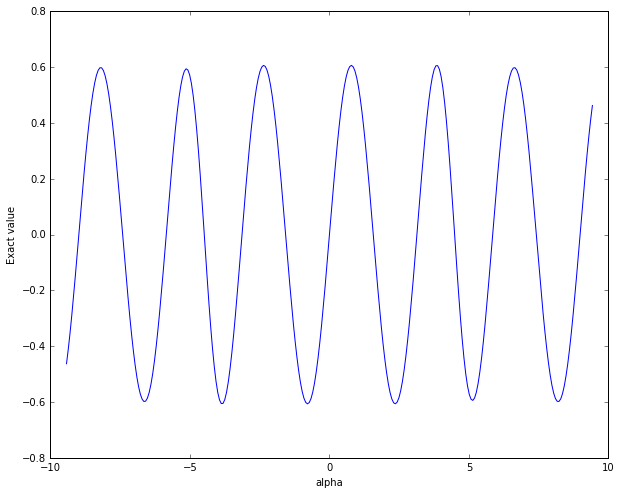

In [14]:
# Plot it
alpha = np.linspace(-3*np.pi, 3*np.pi, 300)
expect_plot = [expect(i) for i in alpha]
plt.plot(alpha, expect_plot)
plt.xlabel("alpha")
plt.ylabel("Exact value")
plt.show()

In [15]:
# Expressing as imaginary part of a displacement operator
tmp = lambda alpha: qutip.expect((0.5j * (qutip.destroy(N) + qutip.create(N))).expm(), qutip.coherent(N, alpha=alpha))
tmp_plot = [np.imag(tmp(i)) for i in alpha]

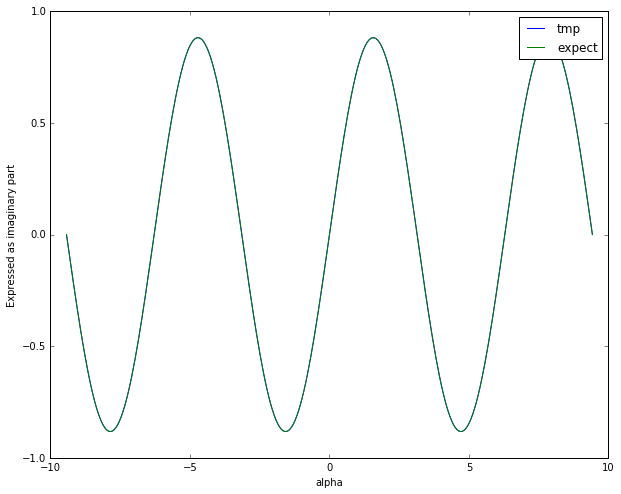

In [253]:
plt.plot(alpha, tmp_plot, label="tmp")
plt.plot(alpha, expect_plot, label="expect")
plt.xlabel("alpha")
plt.ylabel("Expressed as imaginary part")
plt.legend()
plt.show()

In [228]:
# Computing displacement, this expectation value is just a scalar product of coherent states
scalar = lambda alpha: qutip.coherent(N, alpha).dag() * qutip.coherent(N, alpha + 0.5j)

In [244]:
scalar_plot = [scalar(i).full()[0,0] for i in alpha]

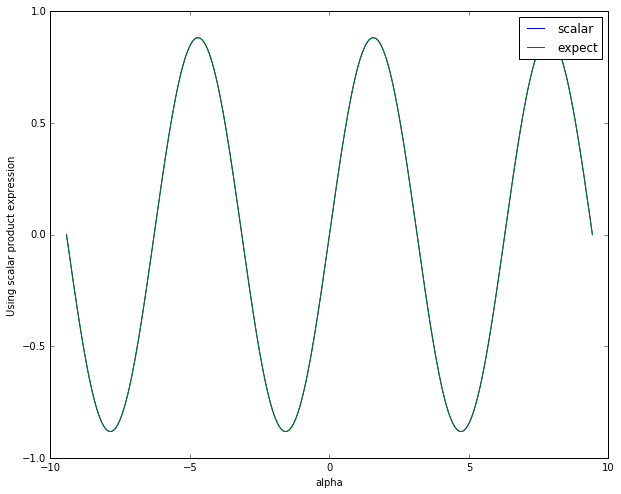

In [254]:
plt.plot(alpha, [float(np.imag(np.exp(0.5j * alpha[i]) * scalar_plot[i])) for i in range(len(scalar_plot))], label="scalar")
plt.plot(alpha, expect_plot, label="expect")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("Using scalar product expression")
plt.show()

## Checking full expansion in $a$ and $a^\dagger$

In [8]:
N = 200  # Large enough Hilbert space
# Original function
s = sinm(phi_0["a"] * (qutip.destroy(N) + qutip.create(N)) / 2)

In [267]:
# Checking equation 47
print(qutip.expect(s, qutip.coherent(N, 3)))
print(
    qutip.expect(
        sum([
                (-1)**i * phi_0["a"]**(2*i + 1) *
                (qutip.destroy(N) + qutip.create(N))**(2*i + 1) /
                (2**(2*i + 1) * scipy.special.factorial(2*i + 1, exact=True))
                for i in range(30)]),
        qutip.coherent(N, 3)))

0.0123330967588735
0.012333096757492883


In [352]:
# Checking equation 56
alpha = np.linspace(0, 3*np.pi, 5)
print([qutip.expect(s, qutip.coherent(N, i)) for i in alpha])
print([
    np.real(qutip.expect(
        phi_0["a"] / 2 * (
            np.exp(-phi_0["a"]**2 / 8) +
            sum([
                    phi_0["a"]**(2*i + 1) *
                    (-1)**i * 2**(-3*i + (k-1) / 2) /
                    (scipy.special.factorial(int(i - (k-1) / 2), exact=True) * scipy.special.factorial(int((k-1) / 2), exact=True) * scipy.special.factorial(int((k+1) / 2), exact=True)) *
                    np.product([
                            (qutip.create(N) * qutip.destroy(N) - j)
                            for j in range(1, int((k-3) / 2))
                        ]) *
                    qutip.create(N) * qutip.destroy(N)
                    for i in range(1, 30)
                    for k in range(3, 2*i + 1) if k % 2 == 1
                ])) *
        qutip.destroy(N),
        qutip.coherent(N, i))) * 2 for i in alpha])

[0.0, 0.00968648563557934, 0.01937206238170822, 0.029055821437059405, 0.03873685416644333]
[0.0, 0.0096866371199287628, 0.019373274239857536, 0.029059911359786302, 0.038746548479715093]


In [348]:
# Checking equation 61
alpha = np.linspace(0.1, 3*np.pi, 5)
print([qutip.expect(s, qutip.coherent(N, i)) for i in alpha])
print([2 * float(np.real(tmp)) for tmp in
      [
        phi_0["a"] / 2 *
        np.exp(-phi_0["a"]**2 / 8) *
        scipy.special.jv(1, phi_0["a"] * i) / (phi_0["a"] * i / 2) *
        qutip.expect(
            qutip.destroy(N),
            qutip.coherent(N, i))
        for i in alpha]])

[0.0881026809652632, 0.5755077099745216, -0.8813940112541306, 0.6394234118472081, -2.6964955546061286e-14]
[0.08813942409944234, 0.9060377046141324, -0.5146172009273269, 0.04104631110233012, 0.31191888164914233]


<IPython.core.display.Javascript object>


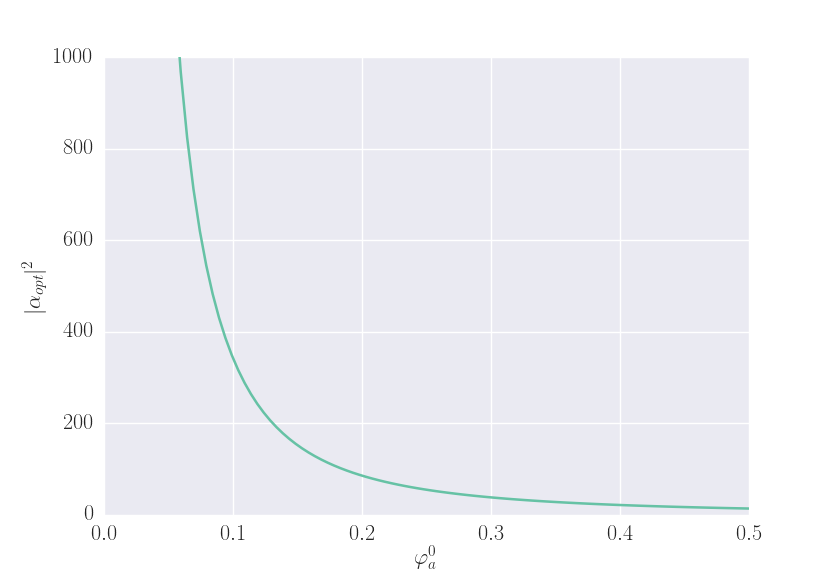

In [35]:
import seaborn

varphi_list = np.linspace(0.01, 0.5, 100)
alpha_list = [(1.851 / varphi)**2 for varphi in varphi_list]
fig, ax = plt.subplots()
ax.tick_params(labelsize=20)
ax.set_ylim(0, 1000)
ax.set_ylabel(r"$|\alpha_{\text{opt}}|^2$", fontsize=20)
ax.set_xlabel(r"$\varphi_a^0$", fontsize=20)
ax.plot(varphi_list, alpha_list)
fig.savefig("/tmp/out.pdf")
#fig.show()

## Full expansion on the $c$ mode

In [9]:
# Gain amplification in a coherent state
gain_in_coherent_state = (lambda alpha, phi:
    24 * np.exp(-phi**2 / 2) * scipy.special.jv(4, 2 * np.abs(alpha) * phi) / (phi * np.abs(alpha))**4)

In [10]:
# Same expression, but discarding the leading exp(-phi_c^2 / 2) prefactor
gain_coherent_state_phialpha_only = lambda phialpha: np.exp(1 / 2) * gain_in_coherent_state(phialpha, 1)

<IPython.core.display.Javascript object>


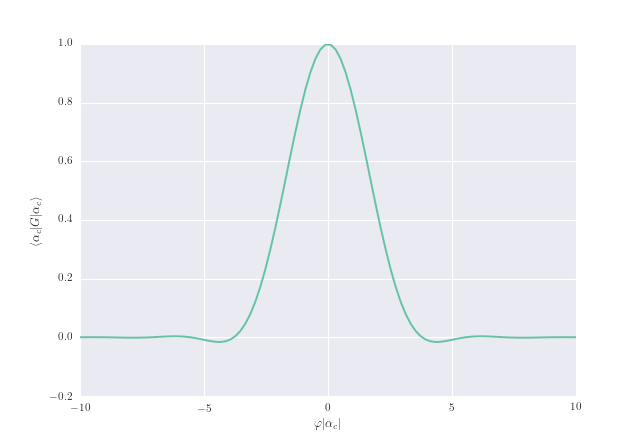

In [11]:
phialpha_list = np.linspace(-10, 10, 100)
gain_coherent_state_phialpha_only_list = [gain_coherent_state_phialpha_only(i) for i in phialpha_list]
plt.plot(phialpha_list, gain_coherent_state_phialpha_only_list)
plt.xlabel(r"$\varphi |\alpha_c|$")
plt.ylabel(r"$\langle \alpha_c | G | \alpha_c \rangle$")
plt.show()

<IPython.core.display.Javascript object>


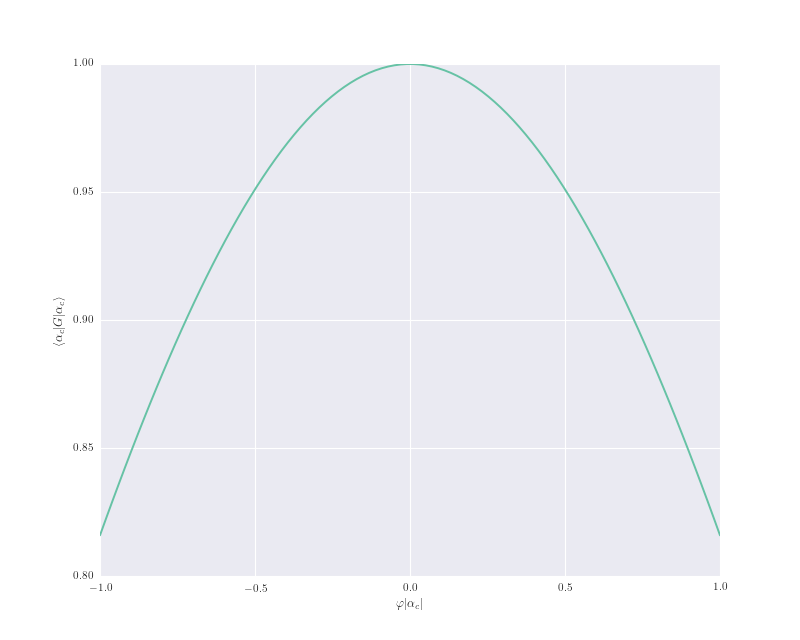

In [54]:
phialpha_list = np.linspace(-1, 1, 100)
gain_coherent_state_phialpha_only_list = [gain_coherent_state_phialpha_only(i) for i in phialpha_list]
plt.plot(phialpha_list, gain_coherent_state_phialpha_only_list)
plt.xlabel(r"$\varphi |\alpha_c|$")
plt.ylabel(r"$\langle \alpha_c | G | \alpha_c \rangle$")
plt.show()

<IPython.core.display.Javascript object>


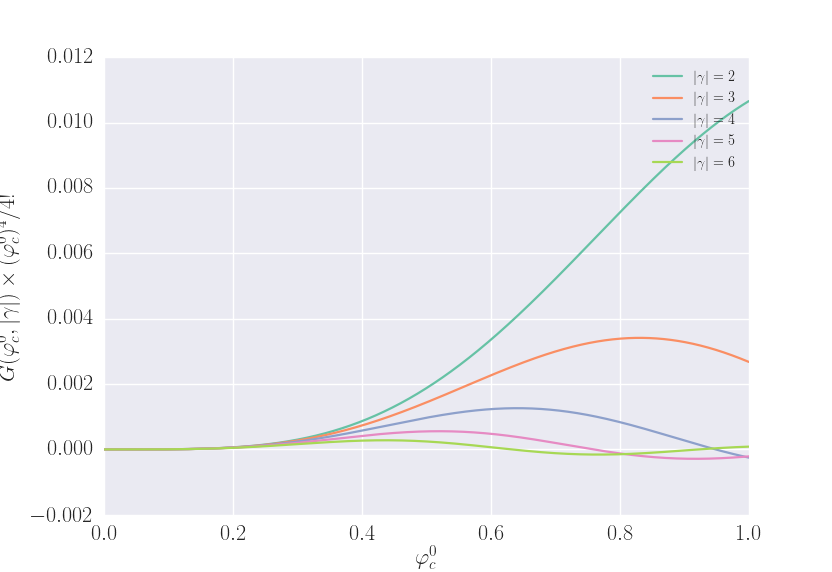

In [56]:
# Let us fix |\alpha_c|, and look for the optimal \varphi_c^0
fig, ax = plt.subplots()
for alpha in range(2, 7):
    phi_list = np.linspace(0.001, 1, 1000)
    ax.plot(phi_list, [gain_in_coherent_state(alpha, phi) * phi**4 / 24 for phi in phi_list],
             label=(r"$|\gamma| = %d$" % (alpha,)),
             linewidth=2.0)

ax.tick_params(labelsize=20)
ax.set_xlabel(r"$\varphi_c^0$", fontsize=20)
ax.set_ylabel(r"$G(\varphi_c^0, |\gamma|) \times (\varphi_c^0)^4 / 4!$", fontsize=20)
ax.legend()
fig.savefig("/tmp/gain_expansion_c_full.pdf")
#fig.show()

<IPython.core.display.Javascript object>


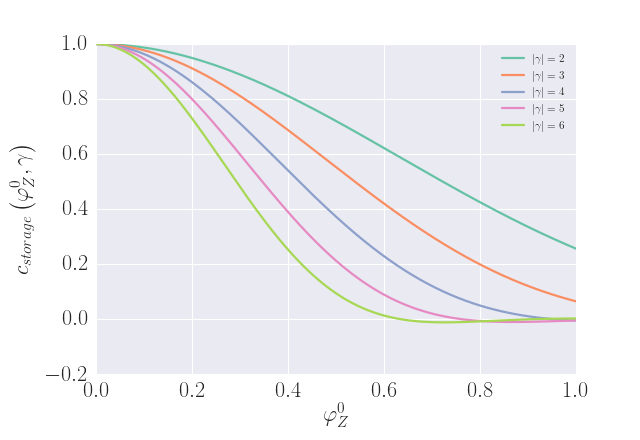

In [15]:
# Let us fix |\alpha_c|, and look for the optimal \varphi_c^0
fig, ax = plt.subplots()
for alpha in range(2, 7):
    phi_list = np.linspace(0.001, 1, 1000)
    ax.plot(phi_list, [gain_in_coherent_state(alpha, phi) for phi in phi_list],
             label=(r"$|\gamma| = %d$" % (alpha,)),
             linewidth=2.0)

ax.tick_params(labelsize=20)
ax.set_xlabel(r"$\varphi_Z^0$", fontsize=20)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#ax.set_ylabel(r"$G(\varphi_c^0, |\gamma|)$", fontsize=20)
ax.set_ylabel(r"$c_{\text{storage}}\left(\varphi_Z^0, \gamma\right)$", fontsize=20)
ax.legend()
fig.savefig("/tmp/gain_expansion_c.pdf")
#fig.show()

<IPython.core.display.Javascript object>


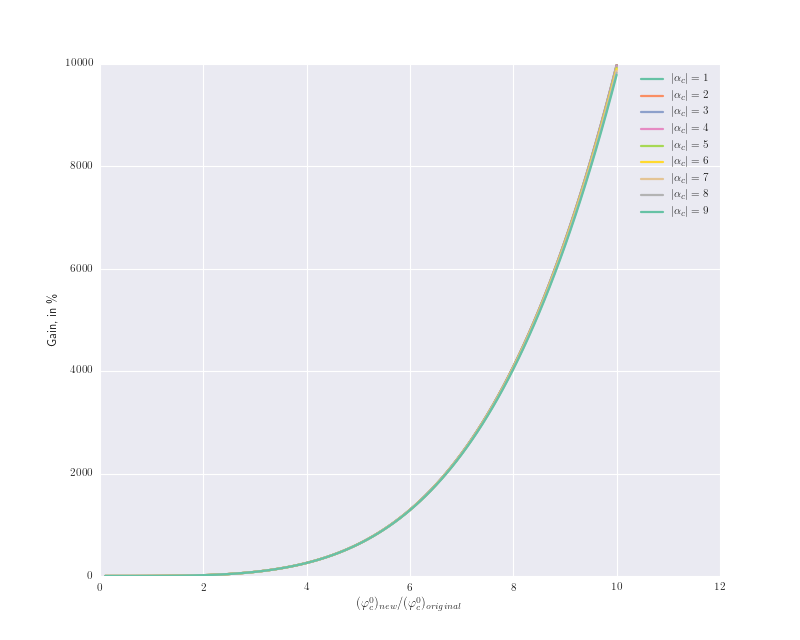

In [56]:
# Let us fix |\alpha_c|, and look at the potential gain by tweaking phi_c^0
for alpha in range(1, 10):
    phi_list = np.linspace(phi_0["c"] / 10, 10 * phi_0["c"], 100)
    plt.plot([i / phi_0["c"] for i in phi_list],
             [gain_in_coherent_state(alpha, phi) * phi**4 / phi_0["c"]**4 for phi in phi_list],
             label=(r"$|\alpha_c| = %d$" % (alpha,)),
             linewidth=2.0)

plt.xlabel(r"$(\varphi_c^0)_{\text{new}} / (\varphi_c^0)_{\text{original}}$")
plt.ylabel("Gain, in \%")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


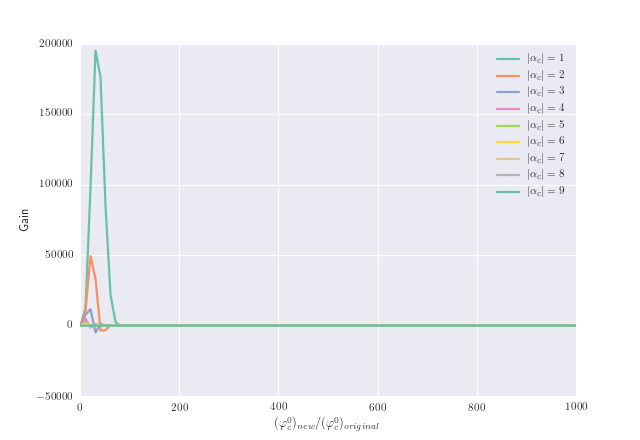

In [27]:
# Let us fix |\alpha_c|, and look at the potential gain by tweaking phi_c^0
for alpha in range(1, 10):
    phi_list = np.linspace(phi_0["c"], 1000 * phi_0["c"], 100)
    plt.plot([i / phi_0["c"] for i in phi_list],
             [gain_in_coherent_state(alpha, phi) * phi**4 / phi_0["c"]**4 for phi in phi_list],
             label=(r"$|\alpha_c| = %d$" % (alpha,)),
             linewidth=2.0)

plt.xlabel(r"$(\varphi_c^0)_{\text{new}} / (\varphi_c^0)_{\text{original}}$")
plt.ylabel("Gain")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


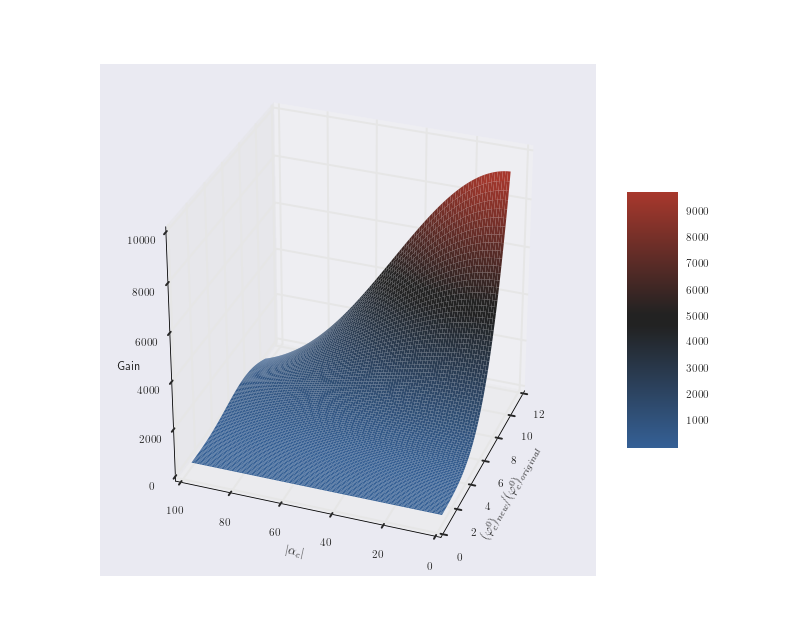

In [123]:
phi_list = np.linspace(phi_0["c"], 10 * phi_0["c"], 100)
alpha_list = np.linspace(1, 100, 100)

phi_list, alpha_list = np.meshgrid(phi_list, alpha_list)

fig = plt.figure()
ax = fig.gca(projection='3d')
cmap = seaborn.diverging_palette(250, 15, s=75, l=40, n=9, center="dark", as_cmap=True)

surf = ax.plot_surface(phi_list / phi_0["c"],
                       alpha_list,
                       (lambda alpha, phi: gain_in_coherent_state(alpha, phi) * phi**4 / phi_0["c"]**4)(alpha_list, phi_list),
                       rstride=1,
                       cstride=1,
                       linewidth=0,
                       antialiased=True,
                       cmap=cmap)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel(r"$(\varphi_c^0)_{\text{new}} / (\varphi_c^0)_{\text{original}}$")
ax.set_ylabel(r"$|\alpha_c|")
ax.set_zlabel("Gain")
ax.view_init(None, 200)

plt.show()

## Simulation of cat state convergence

In [10]:
N = 40
chi = 10**6
kappa_b = 1 / (25 * 10**(-9))
kappa_dict = {
    1: 0,  # kappa_1ph
    4: 4 * chi**2 / kappa_b  # kappa_4ph
}
epsilon_4ph = 8 * kappa_dict[4]
step = 10**(-10)
iterations = 100000
tlist = [i * step for i in range(iterations)]

a = qutip.destroy(N)

def cat_state_convergence_simulation(rho0):
    c_ops = [np.sqrt(kappa) * a**n for n, kappa in kappa_dict.items()]  # List of collapse operators
    e_ops = []  # List of expectation values to evaluate

    results = qutip.mesolve(1.0j * epsilon_4ph * (a.dag()**4 - a**4),
                            rho0,
                            tlist,
                            c_ops,
                            e_ops, args={}, options=None, progress_bar=True)
    return results

In [11]:
alpha_steady = (2 * epsilon_4ph / kappa_dict[4])**(1/4)
print(alpha_steady)

2.0


In [12]:
norm = 1 / np.sqrt(2)

C = lambda alpha, pm: norm * (qutip.coherent(N, alpha) + pm * qutip.coherent(N, -alpha))

C0 = norm * (C(alpha_steady, 1) + C(1.0j * alpha_steady, 1))
C1 = norm * (C(alpha_steady, -1) - C(1.0j * alpha_steady, -1))
C2 = norm * (C(alpha_steady, 1) - C(1.0j * alpha_steady, 1))
C3 = norm * (C(alpha_steady, -1) + C(1.0j * alpha_steady, -1))

optimal_polynomials = lambda x: 16 * x**3 + 24 * x**2 + 56 * x + 24
optimal_polynomials(alpha_steady**2)

1656.0

$\left|\psi(0)\right\rangle = \left|0\right\rangle$

In [38]:
results = cat_state_convergence_simulation(qutip.coherent_dm(N, 0))

10.0%. Run time:  34.91s. Est. time left: 00:00:05:14
20.0%. Run time:  69.66s. Est. time left: 00:00:04:38
30.0%. Run time: 104.60s. Est. time left: 00:00:04:04
40.0%. Run time: 139.45s. Est. time left: 00:00:03:29
50.0%. Run time: 176.01s. Est. time left: 00:00:02:56
60.0%. Run time: 213.09s. Est. time left: 00:00:02:22
70.0%. Run time: 248.10s. Est. time left: 00:00:01:46
80.0%. Run time: 284.01s. Est. time left: 00:00:01:11
90.0%. Run time: 317.66s. Est. time left: 00:00:00:35
Total run time: 350.73s


In [39]:
projectors = [np.real((C0 * C0.dag() * result).tr()) for result in results.states]

<IPython.core.display.Javascript object>


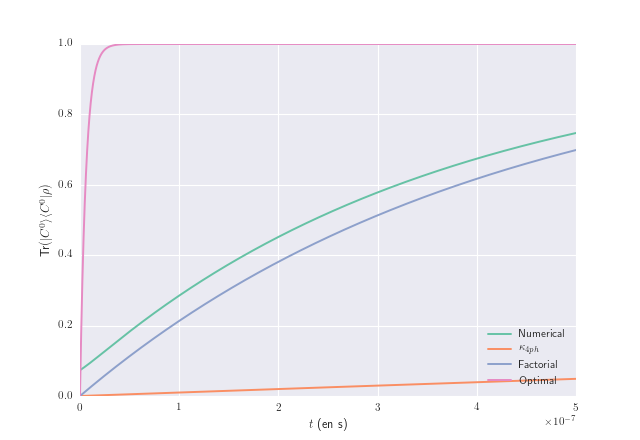

In [40]:
fig, axes = plt.subplots()
axes.plot(tlist, projectors, label="Numerical")
axes.plot(tlist, [1 - np.exp(-kappa_dict[4] * t) for t in tlist], label=r"$\kappa_{4ph}$")
axes.plot(tlist, [1 - np.exp(-24*kappa_dict[4] * t) * np.exp(-4*kappa_dict[1] * t) for t in tlist], label="Factorial")
axes.plot(tlist, [(1 - np.exp(-optimal_polynomials(4)*kappa_dict[4] * t)) * np.exp(-4*kappa_dict[1] * t) for t in tlist], label="Optimal")
axes.legend(loc="lower right")
axes.set_xlabel(r"$t$ (en s)")
axes.set_ylabel(r"Tr$(|C^0 \rangle \langle C^0|\rho)$")
axes.set_xlim(0, 0.0000005)
fig.show()

<IPython.core.display.Javascript object>


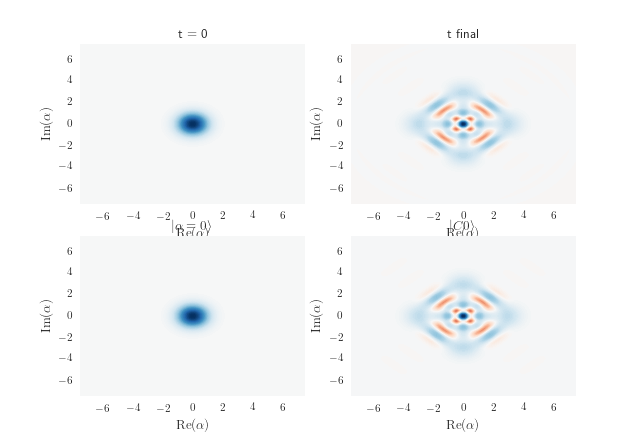

In [17]:
fig, axes = plt.subplots(2, 2)
qutip.plot_wigner(results.states[0], fig=fig, ax=axes[0][0])
axes[0][0].set_title("t = 0")
qutip.plot_wigner(results.states[-1], fig=fig, ax=axes[0][1])
axes[0][1].set_title("t final")
qutip.plot_wigner(qutip.coherent_dm(N, 0), fig=fig, ax=axes[1][0])
axes[1][0].set_title(r"$|\alpha = 0\rangle$")
qutip.plot_wigner(C0, fig=fig, ax=axes[1][1])
axes[1][1].set_title(r"$|C0\rangle$")
fig.show()

$\left|\psi(0)\right\rangle = \left|2\right\rangle$

In [12]:
results = cat_state_convergence_simulation(qutip.fock_dm(N, 2))

10.0%. Run time:  41.74s. Est. time left: 00:00:06:15
20.0%. Run time:  82.64s. Est. time left: 00:00:05:30
30.0%. Run time: 124.25s. Est. time left: 00:00:04:49
40.0%. Run time: 165.65s. Est. time left: 00:00:04:08
50.0%. Run time: 205.74s. Est. time left: 00:00:03:25
60.0%. Run time: 247.19s. Est. time left: 00:00:02:44
70.0%. Run time: 289.66s. Est. time left: 00:00:02:04
80.0%. Run time: 330.58s. Est. time left: 00:00:01:22
90.0%. Run time: 375.30s. Est. time left: 00:00:00:41
Total run time: 421.14s


In [16]:
projectors = [np.real((C2 * C2.dag() * result).tr()) for result in results.states]

<IPython.core.display.Javascript object>


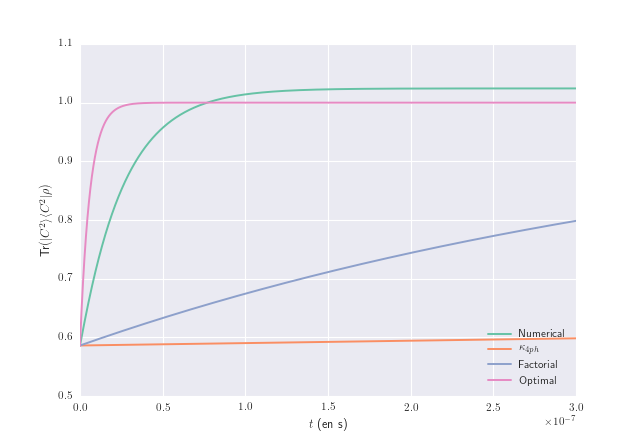

In [37]:
fig, axes = plt.subplots()
axes.plot(tlist, projectors, label="Numerical")
axes.plot(tlist, [projectors[0] + (1 - projectors[0]) * (1 - np.exp(-kappa_dict[4] * t)) for t in tlist], label=r"$\kappa_{4ph}$")
axes.plot(tlist, [projectors[0] + (1 - projectors[0]) * (1 - np.exp(-24*kappa_dict[4] * t)) for t in tlist], label="Factorial")
axes.plot(tlist, [projectors[0] + (1 - projectors[0]) * (1 - np.exp(-optimal_polynomials(4)*kappa_dict[4] * t)) for t in tlist], label="Optimal")
axes.legend(loc="lower right")
axes.set_xlabel(r"$t$ (en s)")
axes.set_ylabel(r"Tr$(|C^2 \rangle \langle C^2|\rho)$")
axes.set_xlim(0, 3e-7)
fig.show()

$\left|\psi(0)\right\rangle = \left|\alpha=3\right\rangle$

In [12]:
results = cat_state_convergence_simulation(qutip.coherent_dm(N, 3))

10.0%. Run time:  39.15s. Est. time left: 00:00:05:52
20.0%. Run time:  77.63s. Est. time left: 00:00:05:10
30.0%. Run time: 115.79s. Est. time left: 00:00:04:30
40.0%. Run time: 155.58s. Est. time left: 00:00:03:53
50.0%. Run time: 195.60s. Est. time left: 00:00:03:15
60.0%. Run time: 235.31s. Est. time left: 00:00:02:36
70.0%. Run time: 273.96s. Est. time left: 00:00:01:57
80.0%. Run time: 313.06s. Est. time left: 00:00:01:18
90.0%. Run time: 353.01s. Est. time left: 00:00:00:39
Total run time: 393.05s


In [13]:
projectors = [np.real((C0 * C0.dag() * result).tr()) for result in results.states]

<IPython.core.display.Javascript object>


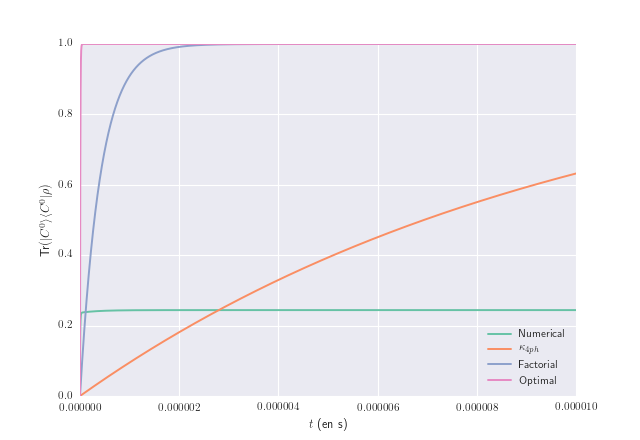

In [14]:
fig, axes = plt.subplots()
axes.plot(tlist, projectors, label="Numerical")
axes.plot(tlist, [1 - np.exp(-kappa_dict[4] * t) for t in tlist], label=r"$\kappa_{4ph}$")
axes.plot(tlist, [(1 - np.exp(-24*kappa_dict[4] * t)) * np.exp(-4*kappa_dict[1] * t) for t in tlist], label="Factorial")
axes.plot(tlist, [(1 - np.exp(-optimal_polynomials(4)*kappa_dict[4] * t)) * np.exp(-4*kappa_dict[1] * t) for t in tlist], label="Optimal")
axes.legend(loc="lower right")
axes.set_xlabel(r"$t$ (en s)")
axes.set_ylabel(r"Tr$(|C^0 \rangle \langle C^0|\rho)$")
fig.show()

$\left| \Psi(0) \right\rangle = C^0_{\alpha_{\text{steady}} e^{-\tau}}$

In [146]:
initial_state = norm * (C(alpha_steady * np.exp(-0.1), 1) + C(1.0j * alpha_steady * np.exp(-0.1), 1))

In [147]:
results = cat_state_convergence_simulation(initial_state)

10.0%. Run time:  29.70s. Est. time left: 00:00:04:27
20.0%. Run time:  59.53s. Est. time left: 00:00:03:58
30.0%. Run time:  89.65s. Est. time left: 00:00:03:29
40.0%. Run time: 119.63s. Est. time left: 00:00:02:59
50.0%. Run time: 150.23s. Est. time left: 00:00:02:30
60.0%. Run time: 181.62s. Est. time left: 00:00:02:01
70.0%. Run time: 213.49s. Est. time left: 00:00:01:31
80.0%. Run time: 246.76s. Est. time left: 00:00:01:01
90.0%. Run time: 277.69s. Est. time left: 00:00:00:30
Total run time: 308.42s


In [148]:
projectors = [np.real((C0 * C0.dag() * result).tr()) for result in results.states]

<IPython.core.display.Javascript object>


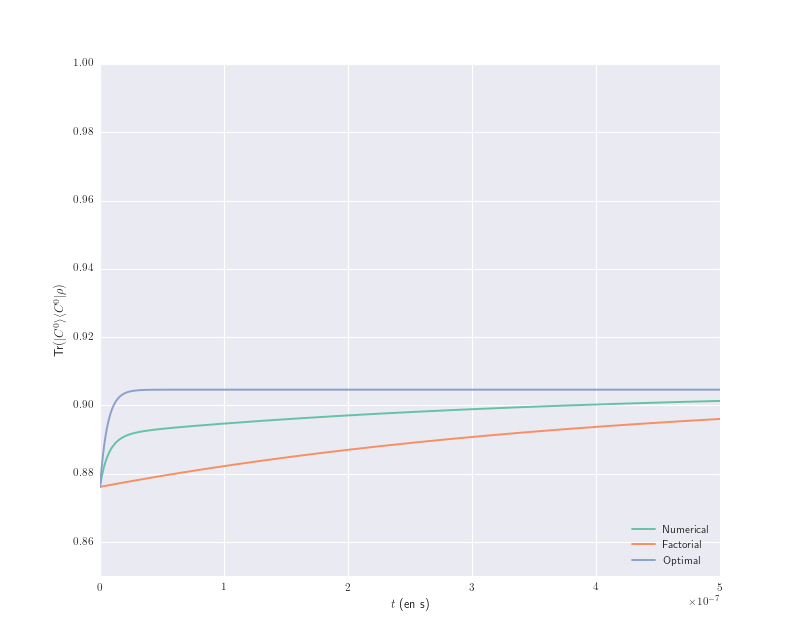

In [162]:
fig, axes = plt.subplots()
axes.plot(tlist, projectors, label="Numerical")
axes.plot(tlist,
          [projectors[0] +
           (projectors[-1] - projectors[0]) * (1 - np.exp(-24*kappa_dict[4] * t))
          for t in tlist], label="Factorial")
axes.plot(tlist,
          [projectors[0] + 
           (projectors[-1] - projectors[0]) * (1 - np.exp(-optimal_polynomials(4)*kappa_dict[4] * t))
          for t in tlist], label="Optimal")
axes.legend(loc="lower right")
axes.set_xlabel(r"$t$ (en s)")
axes.set_ylabel(r"Tr$(|C^0 \rangle \langle C^0|\rho)$")
axes.set_xlim((0, 5e-7))
axes.set_ylim((0.85, 1.0))
fig.show()

$\left| \Psi(0) \right\rangle = C^0_{\alpha_{\text{steady}} e^{i \varphi}}$

In [13]:
initial_state = norm * (C(alpha_steady * np.exp(0.1j), 1) + C(1.0j * alpha_steady * np.exp(0.1j), 1))

In [14]:
results = cat_state_convergence_simulation(initial_state)

10.0%. Run time:  29.08s. Est. time left: 00:00:04:21
20.0%. Run time:  58.56s. Est. time left: 00:00:03:54
30.0%. Run time:  88.46s. Est. time left: 00:00:03:26
40.0%. Run time: 120.50s. Est. time left: 00:00:03:00
50.0%. Run time: 150.65s. Est. time left: 00:00:02:30
60.0%. Run time: 181.66s. Est. time left: 00:00:02:01
70.0%. Run time: 212.20s. Est. time left: 00:00:01:30
80.0%. Run time: 241.37s. Est. time left: 00:00:01:00
90.0%. Run time: 270.18s. Est. time left: 00:00:00:30
Total run time: 298.98s


In [15]:
projectors = [np.real((C0 * C0.dag() * result).tr()) for result in results.states]

<IPython.core.display.Javascript object>


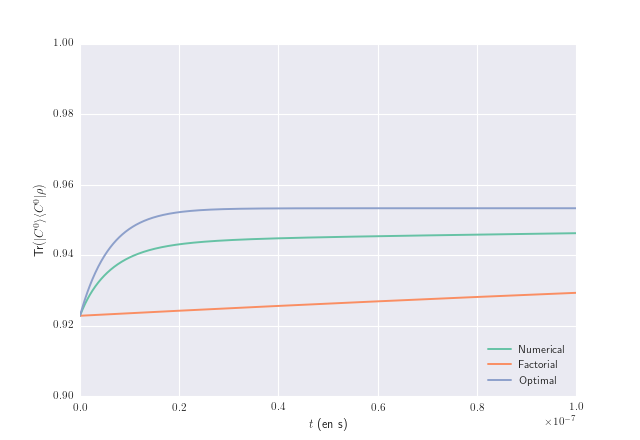

In [16]:
fig, axes = plt.subplots()
axes.plot(tlist, projectors, label="Numerical")
axes.plot(tlist,
          [projectors[0] +
           (projectors[-1] - projectors[0]) * (1 - np.exp(-24*kappa_dict[4] * t))
          for t in tlist], label="Factorial")
axes.plot(tlist,
          [projectors[0] + 
           (projectors[-1] - projectors[0]) * (1 - np.exp(-optimal_polynomials(4)*kappa_dict[4] * t))
          for t in tlist], label="Optimal")
axes.legend(loc="lower right")
axes.set_xlabel(r"$t$ (en s)")
axes.set_ylabel(r"Tr$(|C^0 \rangle \langle C^0|\rho)$")
axes.set_xlim((0, 1e-7))
axes.set_ylim((0.9, 1.0))
fig.show()

## Evolution of convergence rate as a function of $|\alpha_{steady}|$

<IPython.core.display.Javascript object>


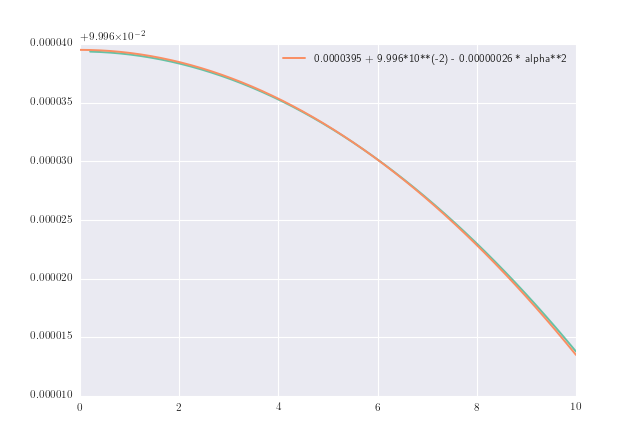

In [43]:
# When in the span of coherent states, the polynomial prefactor is
coherent_span_polynomials = lambda alpha: 16 * np.abs(alpha)**6 + 24 * np.abs(alpha)**4 + 56 * np.abs(alpha)**2 + 24
# Kappa_4ph is given by
chi = 10**6
g_4ph = lambda alpha: chi * gain_in_coherent_state(alpha, phi_0["c"])
kappa_4ph = lambda alpha: 4 * g_4ph(alpha) / kappa_b

# Plot it as a function of alpha_steady
fig, ax = plt.subplots()
alpha_steady_list = np.linspace(0, 10)
convergence_rate_list = [kappa_4ph(alpha) for alpha in alpha_steady_list]
ax.plot(alpha_steady_list, convergence_rate_list)
ax.plot(alpha_steady_list, [0.0000395 + 9.996*10**(-2) - 0.00000026 * alpha**2 for alpha in alpha_steady_list], label="0.0000395 + 9.996*10**(-2) - 0.00000026 * alpha**2")
ax.legend(loc="best")
fig.show()

## Scratchpad

<IPython.core.display.Javascript object>


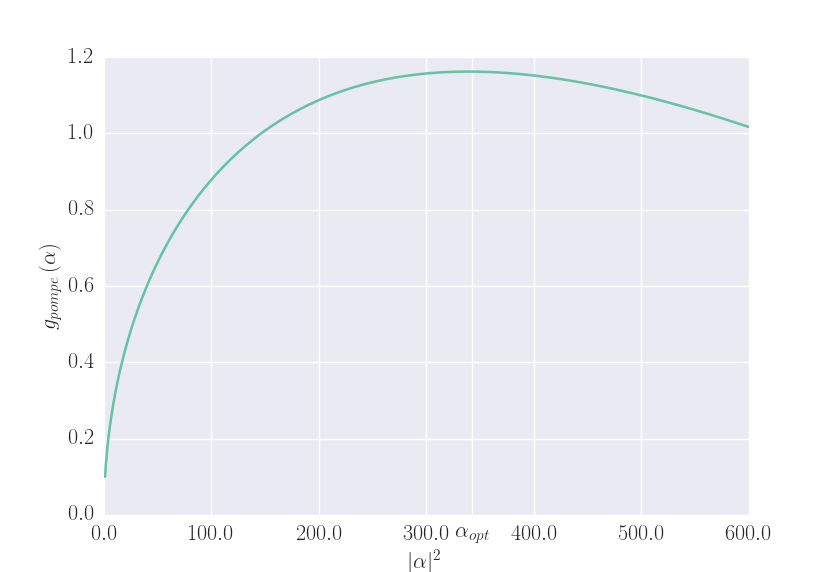

In [94]:
import seaborn

varphi = 0.1
alpha_list = np.linspace(1, np.sqrt(600), 1000)
fig, ax = plt.subplots()
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$|\alpha|^2$", fontsize=20)
ax.set_ylabel(r"$g_{\text{pompe}}\left(\alpha\right)$", fontsize=20)
ax.plot(alpha_list**2, [varphi / 2 * np.exp(-varphi**2 / 8) * (scipy.special.jv(1, np.abs(alpha) * varphi)) / (varphi * alpha / 2) * 2 * alpha for alpha in alpha_list])
locs, labels = ax.get_xticks().tolist(), ["$%s$" % (str(x),) for x in ax.get_xticks().tolist()]
locs.append((1.851 / varphi)**2)
labels.append(r"$\alpha_{\text{opt}}$")
ax.set_xticks(locs)
ax.set_xticklabels(labels)
fig.savefig("/tmp/gpompe.pdf")
#fig.show()